In [1]:
from __future__ import division
import warnings
import string

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

In [2]:
# Information about the data is here: http://anthology.aclweb.org/H/H93/H93-1005.pdf
# feature descriptions: http://www.cs.columbia.edu/~djhsu/coms4721-s16/project/field_types.txt

In [3]:
task = pd.read_csv('../data/data.csv')
quiz = pd.read_csv('../data/quiz.csv')

In [4]:
warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Preprocessing

#### Rename the columns to make them easier to work with

In [5]:
alphabet = list(string.ascii_lowercase)
alphabet2 = alphabet + [l+l for l in alphabet] + ['aaa']

In [6]:
task.columns = alphabet2
quiz.columns = alphabet2[:-1]

#### Create useful column subsets

In [232]:
paired_cols = [
    ['a', 'f', 'k'],
    ['b', 'g', 'l'],
    ['c', 'h', 'm'],
    ['d', 'i', 'n'],
    ['e', 'j', 'o'],
    ['ss', 'tt', 'uu']
]

categorical_cols = [
    'a', 'c', 'd', 'e',
    'f', 'h', 'i', 'j',
    'k', 'l', 'n', 'm',
    'o', 'ss', 'tt', 'uu'
] # 'm',

zero_one_two_cols = [
    'aa', 'bb', 'cc',
    'dd', 'ee', 'ff',
    'gg', 'hh', 'ii',
    'jj', 'kk', 'll',
    'mm', 'nn'
]

boolean_cols = [
    'p', 'q',  's',
    'v', 'w',
    'y', 'z', 'oo',
    'pp', 'qq', 'rr', 
    'xx', 'yy', 'zz'
] #     't', 'u', 'r', 'x',

potentially_useless_cols = [
    'x', 'u', 't', 'r'
]

continuous_cols = [
    'vv', 'ww'
]

#### Column Descriptions
- Data From: THE HCRC MAP TASK CORPUS: NATURAL DIALOGUE FOR SPEECH RECOGNITION 
- The corpus is composed of 128 two-person conversations
- The data is an orthographic transcription
- value of the dataset: "Examples supporting this claim are given, including preliminary evidence of the phonetic consequences of second mention and the impact of different styles of referent negotiation on communicative efficacy."
- In particular, maps and feature names were designed to allow for controlled exploration of phonological reductions of various kinds in a number of different referential contexts, and to provide a range of different stimuli to referent negotiation, based on matches and mis-matches between the two maps.
- __The task was for the participant without the route to draw one on the basis of discussion with the participant with the route.__
- 150,000 word tokens, 2000 word types.  __IDEA:__ We should see if there are columns that wehn tokenized add to 150,000.  There might be words that are highly correlated with the outcome type.
- __QUESTION__: What are the outcomes?  If we can figure that out, it might give us ideas for how to determine which features are most relevant. 
- __QUESTION__: what are f 'accent diagnosis' utterances?
- The transcriptions are at the orthographic level, quito detailed, including filled pauses, false starts and repetitions, broken words, 26 etc. 

#### Observations
- There seem to be 'part of speech' columns
- There are a number of columns that only take on the values 0, 1, or 2.  They could be counts?
- There are a number of boolean columns where there are very few 1s
- __IDEA__: Can we use the token information to determine which colums are the eye contact ones?
- __IDEA__: Are the 0,1,2 codes for None, Definite, Indefinite?
- __QUESTION:__ which are the eye contact and familiarity columns?
- uu and m have the most possible values

#### Column Findings
 - columns d and i are the the roles (Intruction Follower or Giver) and n is the sequence  
 - columnds d,e,f and i,j,k have the same possible values

### Feature Creation

#### One-hot encoding of the categorical columns

In [233]:
final_cols = categorical_cols + zero_one_two_cols + boolean_cols + continuous_cols

In [234]:
X_dummies = pd.get_dummies(task[final_cols])

In [235]:
X_quiz_dummies = pd.get_dummies(quiz[final_cols])

In [236]:
X_train_dummies = X_dummies[[col for col in X_dummies.columns if col in X_quiz_dummies.columns]]

In [237]:
X_quiz_dummies = X_quiz_dummies[[col for col in X_quiz_dummies.columns if col in X_train_dummies.columns]]

In [238]:
X_train_sample = X_train_dummies.sample(20000)

In [239]:
target_cols = [col for col in X_dummies.columns if col in X_quiz_dummies.columns]

In [240]:
sample_ixs = list(X_train_sample.index)

In [241]:
y = task.aaa.as_matrix()
y_sample = y[sample_ixs]

#### Transformation of the Distribution of the Continuous Columns

In [17]:
# from sklearn.preprocessing import FunctionTransformer
# task.ww[task.ww > 10].apply(np.log)
# task.vv[task.vv > 10].apply(np.log)

#### Polynomial Feature Expansion

In [18]:
from sklearn.preprocessing import PolynomialFeatures

In [79]:
X_poly = PolynomialFeatures(interaction_only=True).fit_transform(X)

### Feature Selection

#### Dropping redundant columns

In [19]:
from sklearn.feature_selection import VarianceThreshold
# TODO: # Find correlated features and drop them
# task.drop(potentially_useless_cols, inplace=True)
# sel = VarianceThreshold(threshold=(.9 * (1 - .9)))
# X_reduced = sel.fit_transform(X_dummies)

#### Recursive feature elemination

In [20]:
# from sklearn.feature_selection import RFE
# svc = SVC(kernel="linear", C=1)
# rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
# rfe.fit(X, y)
# ranking = rfe.ranking_.reshape(digits.images[0].shape)

#### Select K Best

In [21]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [22]:
# X_new = SelectKBest(chi2, k=1000).fit_transform(X_, y)

#### Models Scoring Feature Selection (SelectFromModel)

In [23]:
from sklearn.cross_validation import train_test_split

In [24]:
from sklearn.feature_selection import SelectFromModel

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=200, n_jobs=-1)

In [50]:
X = SelectFromModel(rf_clf).fit_transform(X_train_sample.as_matrix(), y=y)

#### Reducing Highest Valued Columns

#### Custom Model Scoring Feature Selection

In [61]:
def score_features(clf, X, y, n_iterations=1):
    rankings = []
    for it in range(n_iterations):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        rf_clf.fit(X, y)
        rankings.append(clf.feature_importances_)
    return np.array(rankings)

In [156]:
feats = score_features(rf_clf, X_train_sample.as_matrix(), y_sample, n_iterations=10)

In [157]:
# pd.Series(feats.sum(axis=0)).order(ascending=False).iloc[:50].plot(kind='bar', figsize=(18,4))

In [158]:
best_features = list(pd.Series(feats.sum(axis=0)).order(ascending=False).iloc[:100].index)

In [193]:
best_cols = X_train_dummies.columns[best_features]
# best_cols

In [160]:
# What is this?
# X_train_sample.reset_index()
# X = X_train_sample[X_train_sample[best_cols[:100]].mean(axis=1) > .25]

In [195]:
X = X_train_sample[best_cols[:10]].as_matrix()

In [40]:
# X_train_sample.ix[ws, best_cols[:100]]
# new_x = X_train_sample.reset_index().drop('index', 1)

### Testing the Estimators

In [171]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier

In [27]:
from sklearn import svm

In [181]:
rf_clf = RandomForestClassifier(n_estimators=200, n_jobs=-1)

In [182]:
et_clf = ExtraTreesClassifier(n_estimators=200, n_jobs=-1)

In [183]:
gb_clf = GradientBoostingClassifier(n_estimators=200)

In [184]:
e_clf = VotingClassifier(estimators=[('rf', rf_clf), ('et', et_clf), ('gb', gb_clf)], voting='hard')

In [55]:
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C)
lin_svc = svm.LinearSVC(C=C)

#### Cross Validation

In [59]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score

##### Ensemble methods

In [244]:
# cv_scores = cross_val_score(rf_clf, X_train_dummies, y, cv=3)
# cv_scores

In [147]:
cv_scores = cross_val_score(et_clf, X_train_dummies, y, cv=3)
cv_scores

array([ 0.93907285,  0.94335249,  0.94067837])

In [188]:
cv_scores = cross_val_score(e_clf, X_train_dummies, y, cv=2)
cv_scores

array([ 0.9392611 ,  0.94026932])

In [245]:
rf_clf.fit(X_train_dummies, y)

KeyboardInterrupt: 

In [168]:
preds = rf_clf.predict(X_quiz_dummies)

In [169]:
pred = pd.DataFrame(preds).reset_index()
pred.columns = ['Id', 'Prediction']
pred.Id = pred.Id + 1
pred.to_csv('../data/pred5.csv', index=False)

##### SVM

In [53]:
cv_scores = cross_val_score(svc, X, y_sample, cv=3)
cv_scores

array([ 0.87522496,  0.85962807,  0.85834334])

In [52]:
cv_scores = cross_val_score(rbf_svc, X, y_sample, cv=3)
cv_scores

array([ 0.66946611,  0.65626875,  0.66446579])

In [ ]:
cv_scores = cross_val_score(poly_svc, X, y_sample, cv=3)
cv_scores

#### Iterative CV Scores

In [31]:
rf_clf = RandomForestClassifier(n_estimators=200, n_jobs=-1)

In [85]:
def iterative_cv_scores(clf, X, y, n_iterations=1):
    n_iterations = 5
    scores = []
    for ix in range(n_iterations):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        score = clf.fit(X_train, y_train).score(X_test, y_test)
        scores.append(score)
    return scores

In [87]:
iter_scores = iterative_cv_scores(rf_clf, X, y_sample, n_iterations=10)

#### K-Fold

In [43]:
kf = KFold(n=X_train_dummies.shape[0]-1, n_folds=6, shuffle=False, random_state=None)

In [44]:
def kfold_cv_scores(clf, X, y, kf):
    scores = []
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        score = clf.fit(X_train, y_train).score(X_test, y_test)
        scores.append(score)
    print scores

### Diagnostics

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split

In [90]:
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(y_test, rf_clf.predict_proba(X_test)[:,1])

# Calculate the AUC
roc_auc = auc(fpr, tpr)
print 'ROC AUC: %0.2f' % roc_auc
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

NameError: name 'y_test' is not defined

#### True Positive Rate

In [232]:
# sns.distplot(tpr)

#### False Positive Rate

In [235]:
# sns.distplot(fpr)

#### Confusion Matrix

In [32]:
from sklearn.metrics import confusion_matrix

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y_sample, test_size=0.3)

In [186]:
y_pred = rf_clf.predict(X_test)

In [188]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

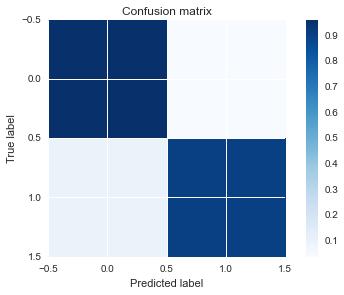

In [189]:
plot_confusion_matrix(cm_normalized)

In [46]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Classification Report

In [190]:
from sklearn.metrics import classification_report

In [191]:
# Precision is higher for 1 than -1
# Recall is higher for -1 than for 1
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

         -1       0.93      0.96      0.94     28584
          1       0.95      0.90      0.93     22151

avg / total       0.94      0.94      0.94     50735



### identifying the incorrectly classified data points

In [197]:
def misclassified_counts(clf, X, y, n_iterations=1):
    """ Creates a matrix of classification outcomes """
    fps = []
    fns = []
    tps = []
    tns = []
    preds = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=33)
    for it in range(n_iterations):
        rf_clf = RandomForestClassifier(n_estimators=200, n_jobs=-1)
        rf_clf.fit(X_train, y_train)
        y_preds = rf_clf.predict(X_test)
        pred_df = pd.DataFrame({'true': y_test, 'pred': y_preds })
        fps.append(((pred_df.true==1) & (pred_df.pred==-1)).astype(int).values)
        fns.append(((pred_df.true==-1) & (pred_df.pred==1)).astype(int).values)
        tps.append(((pred_df.true==1) & (pred_df.pred==1)).astype(int).values)
        tns.append(((pred_df.true==-1) & (pred_df.pred==-1)).astype(int).values)
        preds.append((pred_df.true!=pred_df.pred).astype(int).values)
    return (np.array(fps), np.array(fns), np.array(tps), np.array(tns), np.array(preds))

In [198]:
fps, fns, tps, tns, preds = misclassified_counts(rf_clf, X, y_sample, 30)

In [202]:
fpss = pd.Series(fps.sum(axis=0))
tpss = pd.Series(tps.sum(axis=0))
fnss = pd.Series(fns.sum(axis=0))
tnss = pd.Series(tns.sum(axis=0))
predss = pd.Series(np.array(preds).sum(axis=0))
predsdf = pd.DataFrame(preds)

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y_sample, test_size=0.4, random_state=33)

In [208]:
rf_clf.fit(X_train, y_train).score(X_test, y_test)

0.83862499999999995

In [204]:
wrong = pd.DataFrame({
    'false_positives': fpss.values, 
    'false_negatives': fnss.values, 
    'total_wrong': (fpss + fnss)
})
wrong['prop_fn'] = wrong.false_negatives / wrong.total_wrong
wrong['prop_fp'] = wrong.false_positives / wrong.total_wrong

In [216]:
# ws = wrong[wrong.total_wrong > 10].index
fpdf = wrong[(wrong.prop_fp > .9) & (wrong.total_wrong > 10)]
fndf = wrong[(wrong.prop_fn > .9) & (wrong.total_wrong > 10)]

In [209]:
fpixs = [ix for ix in range(X_test.shape[0]) if ix not in fpdf.index]
fpixs = [ix for ix in range(X_test.shape[0]) if ix not in fndf.index]

In [ ]:
# pd.DataFrame(X[tpss[tpss > 25].index]).mean()

In [ ]:
# pd.DataFrame(X[fpdf.index]).mean()

In [255]:
X_test = X_test[ixs]
y_test = y_test[ixs]

In [108]:
def entropy(p):
    if p != 0:
        return -p * np.log2(p)
    else:
        return 0

In [109]:
# ent = predsdf.sum().apply(lambda v: entropy(v/20))

#### Miscellany

In [42]:
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

In [ ]:
# X = X_train_sample[best_cols[:50]].ix[:100, 2:].as_matrix()

In [77]:
similarities = euclidean_distances(X)

In [78]:
mds = manifold.MDS(n_components=2, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)

In [80]:
# pos = mds.fit(similarities).embedding_

In [52]:
pos.shape

(100, 2)

In [63]:
posdf = pd.DataFrame(pos, columns= ['x', 'y'])
posdf['label'] = y_test[:100]
posdf['wrong'] = (wrong.total_wrong > 3).astype(int)[:100]

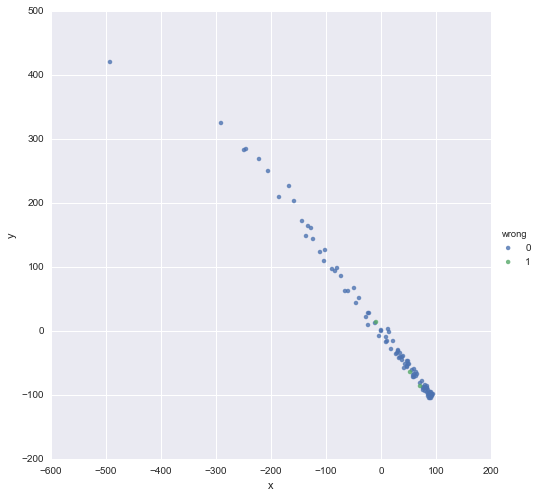

In [64]:
sns.lmplot('x', 'y', posdf, fit_reg=False, hue='wrong', size=7)

In [ ]:
# check for separability. Nope, not separable.
# http://stats.stackexchange.com/questions/47923/test-for-linear-separability